In [9]:
import Environment_non_stationary
import Shop
from mab.ucb_learner import *
from utilities import *

In [10]:
shop_small_ts = Shop.Shop()
shop_ucb = Shop.Shop()

shop_ts = Shop.Shop()
shop_big_ts = Shop.Shop()
shop_c = Shop.Shop()

env = Environment_non_stationary.Environment(shop_small_ts.prices1, shop_small_ts.prices2, shop_small_ts.discounts, 3)

shop_small_ts.set_conv_rate(env.true_conv1[0], env.true_conv2[0])
shop_ucb.set_conv_rate(env.true_conv1[0], env.true_conv2[0])

shop_ts.set_conv_rate(env.true_conv1[0], env.true_conv2[0])
shop_big_ts.set_conv_rate(env.true_conv1[0], env.true_conv2[0])
shop_c.set_conv_rate(env.true_conv1[0], env.true_conv2[0])


price_arms = [(i, j) for i in range(len(shop_small_ts.prices1)) for j in range(len(shop_small_ts.prices2))]
n_price_arms = len(price_arms)

matching_arms = [(i, j, k, l) for i in range(len(shop_ts.prices1)) for j in range(len(shop_ts.prices2)) for k in range(shop_ts.n_classes) for l in range(len(shop_ts.discounts))]
n_matching_arms = len(matching_arms)

small_matching_arms = [(i, j) for i in range(shop_small_ts.n_classes) for j in range(len(shop_small_ts.discounts))]
small_n_matching_arms = len(small_matching_arms)

shop_small_ts.set_assignment_learner('TS', small_n_matching_arms)
shop_ucb.set_assignment_learner('UCB', small_n_matching_arms)

shop_small_ts.set_price_learner('TS', 5)
shop_ucb.set_price_learner('UCB', 5)

shop_small_ts.set_price2_learner('TS', 5)
shop_ucb.set_price2_learner('UCB', 5)

shop_ts.set_price_learner('TS', n_price_arms)
shop_ts.set_assignment_learner('TS', n_matching_arms)


shop_big_ts.set_assignment_learner('TS', n_matching_arms)

In [11]:
generated_promo_ratios = np.array([0.4, 0.25, 0.2, 0.15])
max_ind_reward = max(env.prices1) + max(env.prices2)

In [12]:
shop_c.set_expected_customers(np.array([25, 25, 25, 25]))
cec = shop_c.get_customer_list()
cep = shop_c.get_promo_list(generated_promo_ratios)

clairvoyant_promo_fractions = []
clairvoyant_p1s = []
clairvoyant_p2s = []
clairvoyant_p1_idxs = []
clairvoyant_p2_idxs = []
for i in range(env.n_phases):
    shop_c.set_conv_rate(env.true_conv1[i], env.true_conv2[i])

    cmt, cpa, cer, ers  = shop_c.get_clairvoyant_prices_and_matching(cec, cep, 5, 5)
    cp1idx = price_arms[cpa][0]
    cp2idx = price_arms[cpa][1]
    cp1 = env.prices1[cp1idx]
    cp2 = env.prices2[cp2idx]

    cpf = shop_c.get_promo_fractions_from_tuples(cmt)

    clairvoyant_promo_fractions.append(cpf)
    clairvoyant_p1s.append(cp1)
    clairvoyant_p2s.append(cp2)
    clairvoyant_p1_idxs.append(cp1idx)
    clairvoyant_p2_idxs.append(cp2idx)



In [13]:
clairvoyant_promo_fractions

[array([[0.2, 0. , 0.8, 0. ],
        [0.4, 0. , 0. , 0.6],
        [1. , 0. , 0. , 0. ],
        [0. , 1. , 0. , 0. ]]),
 array([[1. , 0. , 0. , 0. ],
        [0. , 1. , 0. , 0. ],
        [0.4, 0. , 0. , 0.6],
        [0.2, 0. , 0.8, 0. ]]),
 array([[0.6, 0. , 0.4, 0. ],
        [0. , 1. , 0. , 0. ],
        [0. , 0. , 0.4, 0.6],
        [1. , 0. , 0. , 0. ]])]

In [14]:
days = 365

u_rewards_per_class_per_day = []
small_ts_rewards_per_class_per_day = []

ts_rewards_per_class_per_day = []
big_ts_rewards_per_class_per_day = []
c_rewards_per_class_per_day = []

customers_em = np.array([0, 0, 0, 0])
customers_ie = np.array([25, 25, 25, 25])

for day in range(days):
    if day == 0:
        shop_ts.set_expected_customers(customers_ie)
        shop_big_ts.set_expected_customers(customers_ie)
        shop_ucb.set_expected_customers(customers_ie)
        shop_small_ts.set_expected_customers(customers_ie)
    else:
        customers_em = (customers_em*(day-1) + env.customers) / day
        shop_ucb.set_expected_customers((customers_em + 0.99).astype(int))
        shop_small_ts.set_expected_customers((customers_em + 0.99).astype(int))
        shop_ts.set_expected_customers((customers_em + 0.99).astype(int))
        shop_big_ts.set_expected_customers((customers_em + 0.99).astype(int))
    
    # select the price for 2 step learner
    chosen_price_tuple_idx_ts = shop_ts.price_learner.pull_arm()

    price1idx_ts = price_arms[chosen_price_tuple_idx_ts][0]
    price2idx_ts = price_arms[chosen_price_tuple_idx_ts][1]
    price1_ts = env.prices1[price_arms[chosen_price_tuple_idx_ts][0]]
    price2_ts = env.prices2[price_arms[chosen_price_tuple_idx_ts][1]]

    # perform matching and get promo fractions for 2 step learner
    expected_customers_ts = shop_ts.get_customer_list()
    expected_promos_ts = shop_ts.get_promo_list(generated_promo_ratios)
    matched_tuples_ts = shop_ts.assignment_learner.pull_arm_matching(expected_customers_ts, expected_promos_ts, matching_arms, price1idx_ts, price2idx_ts)
    promo_fractions_ts = shop_ts.get_promo_fractions_from_tuples(matched_tuples_ts)

    # get promo fractions and prices for big learner
    expected_customers_big_ts = shop_big_ts.get_customer_list()
    expected_promos_big_ts = shop_big_ts.get_promo_list(generated_promo_ratios)
    matched_tuples_big_ts, price_arm_index_big_ts = shop_big_ts.assignment_learner.pull_arm_all(expected_customers_big_ts, expected_promos_big_ts, matching_arms, len(env.prices1), len(env.prices2))
    promo_fractions_big_ts = shop_big_ts.get_promo_fractions_from_tuples(matched_tuples_big_ts)

    price1idx_big_ts = price_arms[price_arm_index_big_ts][0]
    price2idx_big_ts = price_arms[price_arm_index_big_ts][1]
    price1_big_ts = env.prices1[price1idx_big_ts]
    price2_big_ts = env.prices2[price2idx_big_ts]

    # get expected list of customers
    expected_customers_u = shop_ucb.get_customer_list()
    expected_customers_small_ts = shop_small_ts.get_customer_list()

    # get expected list of promos
    expected_promos_u = shop_ucb.get_promo_list(generated_promo_ratios) 
    expected_promos_small_ts = shop_small_ts.get_promo_list(generated_promo_ratios) 

    #Pull arm price1 from learners 
    chosen_price1_small_ts = env.prices1[shop_small_ts.price_learner.pull_arm()]
    chosen_price1_ucb = env.prices1[shop_ucb.price_learner.pull_arm()] 

    #Pull arm price2 from learners 
    chosen_price2_small_ts = env.prices2[shop_small_ts.price2_learner.pull_arm()]
    chosen_price2_ucb = env.prices2[shop_ucb.price2_learner.pull_arm()] 
    

    # generate the connections and their expected weights
    matched_tuples_u = shop_ucb.assignment_learner.pull_arm_matching(expected_customers_u, expected_promos_u, small_matching_arms)
    matched_tuples_small_ts = shop_small_ts.assignment_learner.pull_arm_matching(expected_customers_small_ts, expected_promos_small_ts, small_matching_arms)
 
    promo_fractions_u = shop_ucb.get_promo_fractions_from_tuples(matched_tuples_u)
    promo_fractions_small_ts = shop_small_ts.get_promo_fractions_from_tuples(matched_tuples_small_ts)

    # simulate the day
    env.generate_next_day_customers()

    enum_customers = list(enumerate(env.customers))
    customers = np.concatenate([np.ones(c).astype(int)*p for p,c in enum_customers])
    np.random.shuffle(customers)

    revenue_small_ts = []
    revenue_ucb = []
    revenue_ts = []
    revenue_big_ts = []
    revenue_c = []

    small_ts_total_reward = 0
    ucb_total_reward = 0
    big_ts_total_reward = 0
    ts_total_reward = 0
    c_total_reward = 0

    c_count = 0

    phase = env.get_phase(days) % env.n_phases

    for cust in customers:
        ts_ind_reward = 0

        selected_promo_small_ts = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_small_ts[cust])
        selected_promo_u = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_u[cust])
        selected_promo_ts = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_ts[cust])
        selected_promo_big_ts = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_big_ts[cust])
        selected_promo_c = np.random.choice([0, 1, 2, 3], 1, p=clairvoyant_promo_fractions[phase][cust])

        small_ts_buy1 = env.round1(cust, chosen_price1_small_ts)
        small_ts_buy2 = 0
        if small_ts_buy1:
            small_ts_buy2 = env.round2(cust, selected_promo_small_ts, chosen_price2_small_ts)
        
        u_buy1 = env.round1(cust, chosen_price1_ucb)
        u_buy2 = 0
        if u_buy1:
            u_buy2 = env.round2(cust, selected_promo_u, chosen_price2_ucb)

        ts_buy1 = env.round1(cust, price1_ts)
        ts_buy2 = 0
        if ts_buy1:
            ts_buy2 = env.round2(cust, selected_promo_ts, price2_ts)

        big_ts_buy1 = env.round1(cust, price1_big_ts)
        big_ts_buy2 = 0
        if big_ts_buy1:
            big_ts_buy2 = env.round2(cust, selected_promo_big_ts, price2_big_ts)


        c_buy1 = env.round1(cust, clairvoyant_p1s[phase], days)
        c_buy2 = 0
        if c_buy1:
            c_buy2 = env.round2(cust, selected_promo_c, clairvoyant_p2s[phase], days)
        
        small_ts_ind_reward= small_ts_buy1*chosen_price1_small_ts + small_ts_buy2*chosen_price2_small_ts*(1-shop_small_ts.discounts[selected_promo_small_ts])
        u_ind_reward = u_buy1*chosen_price1_ucb + u_buy2*chosen_price2_ucb*(1-shop_ucb.discounts[selected_promo_u])
        ts_ind_reward = ts_buy1*price1_ts + ts_buy2*price2_ts*(1-shop_ts.discounts[selected_promo_ts])
        big_ts_ind_reward = big_ts_buy1*price1_big_ts + big_ts_buy2*price2_big_ts*(1-shop_big_ts.discounts[selected_promo_big_ts])
        c_ind_reward = c_buy1*clairvoyant_p1s[phase] + c_buy2*clairvoyant_p2s[phase]*(1-shop_c.discounts[selected_promo_c])
        
        norm_small_ts_ind_reward = small_ts_ind_reward / max_ind_reward
        norm_u_ind_reward = u_ind_reward / max_ind_reward
        norm_ts_ind_reward = ts_ind_reward / max_ind_reward
        norm_big_ts_ind_reward = big_ts_ind_reward / max_ind_reward
        norm_c_ind_reward = c_ind_reward / max_ind_reward

        # update price learner and assignment learner
        shop_ucb.assignment_learner.update(small_matching_arms.index((cust, selected_promo_u)), norm_u_ind_reward)
        shop_small_ts.assignment_learner.update(small_matching_arms.index((cust, selected_promo_small_ts)), norm_small_ts_ind_reward)
        
        shop_ts.price_learner.update(chosen_price_tuple_idx_ts, norm_ts_ind_reward)
        matching_arm_index_ts = matching_arms.index((price1idx_ts, price2idx_ts, cust, selected_promo_ts))
        shop_ts.assignment_learner.update(matching_arm_index_ts, norm_ts_ind_reward)

        # buradaki matching arm index sadece price ikilisini veriyor
        matching_arm_index_big_ts = matching_arms.index((price1idx_big_ts, price2idx_big_ts, cust, selected_promo_big_ts))
        shop_big_ts.assignment_learner.update(matching_arm_index_big_ts, norm_big_ts_ind_reward)

        revenue_ucb.append(u_ind_reward)
        revenue_small_ts.append(small_ts_ind_reward)
        revenue_ts.append(ts_ind_reward)
        revenue_big_ts.append(big_ts_ind_reward)
        revenue_c.append(c_ind_reward)

    small_ts_rewards_per_class_per_day.append(np.mean(revenue_small_ts))
    u_rewards_per_class_per_day.append(np.mean(revenue_ucb))
    ts_rewards_per_class_per_day.append(np.mean(revenue_ts))
    big_ts_rewards_per_class_per_day.append(np.mean(revenue_big_ts))
    c_rewards_per_class_per_day.append(np.mean(revenue_c))
    
    shop_c.detect_phase_change(c_rewards_per_class_per_day[-1])

AttributeError: 'Environment' object has no attribute 'get_phase'

Text(0, 0.5, 'Revenue')

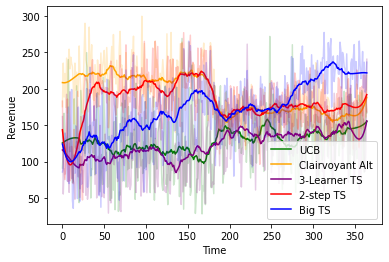

In [6]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

plt.plot(u_rewards_per_class_per_day, color='green', alpha=0.2)
plt.plot(savgol_filter(u_rewards_per_class_per_day, 41, 3), color='green',label='UCB')
plt.plot(c_rewards_per_class_per_day, color='orange', alpha=0.2)
plt.plot(savgol_filter(c_rewards_per_class_per_day, 41, 3), color='orange',label='Clairvoyant Alt')
plt.plot(small_ts_rewards_per_class_per_day, color='purple', alpha=0.2)
plt.plot(savgol_filter(small_ts_rewards_per_class_per_day, 41, 3), color='purple',label='3-Learner TS')
plt.plot(ts_rewards_per_class_per_day, color='red', alpha=0.2)
plt.plot(savgol_filter(ts_rewards_per_class_per_day, 41, 3), color='red', label='2-step TS')
plt.plot(big_ts_rewards_per_class_per_day, color='blue', alpha=0.2)
plt.plot(savgol_filter(big_ts_rewards_per_class_per_day, 41, 3), color='blue', label='Big TS')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Revenue')

Text(0, 0.5, 'Cumulative Revenue')

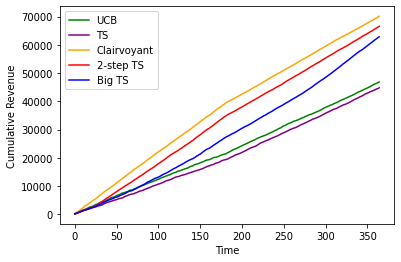

In [7]:
plt.plot(np.cumsum(u_rewards_per_class_per_day), color='green', label='UCB')
plt.plot(np.cumsum(small_ts_rewards_per_class_per_day), color='purple', label='TS')
plt.plot(np.cumsum(c_rewards_per_class_per_day), color='orange', label='Clairvoyant')
plt.plot(np.cumsum(ts_rewards_per_class_per_day), color='red', label='2-step TS')
plt.plot(np.cumsum(big_ts_rewards_per_class_per_day), color='blue', label='Big TS')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Cumulative Revenue')

Text(0, 0.5, 'Regret')

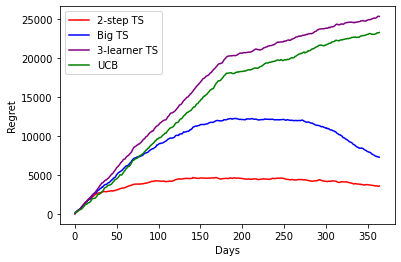

In [8]:
plt.plot(np.cumsum(np.array(c_rewards_per_class_per_day) - np.array(ts_rewards_per_class_per_day)), color='red', label='2-step TS')
plt.plot(np.cumsum(np.array(c_rewards_per_class_per_day) - np.array(big_ts_rewards_per_class_per_day)), color='blue', label='Big TS')
plt.plot(np.cumsum(np.array(c_rewards_per_class_per_day) - np.array(small_ts_rewards_per_class_per_day)), color='purple', label='3-learner TS')
plt.plot(np.cumsum(np.array(c_rewards_per_class_per_day) - np.array(u_rewards_per_class_per_day)), color='green', label='UCB')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Regret')